绘图函数

In [8]:
%matplotlib widget
import matplotlib.pyplot as plt

import torch
from d2l import torch as d2l

class Animator:
    """用于动画化绘制数据的类"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), figsize=(4, 3)):
        self.fig, self.ax = plt.subplots(figsize=figsize)
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.legend = legend if legend is not None else []
        self.fmts = fmts
        self.X = [[] for _ in range(len(self.fmts))]
        self.Y = [[] for _ in range(len(self.fmts))]

        # 设置坐标轴属性
        self.ax.set(xlabel=xlabel, ylabel=ylabel)
        if xlim: self.ax.set_xlim(*xlim)
        if ylim: self.ax.set_ylim(*ylim)
        self.ax.set_xscale(xscale)
        self.ax.set_yscale(yscale)

    def add(self, x, y):
        """向图表中添加多个数据点"""
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n

        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)

        self.ax.clear()
        for xi, yi, fmt in zip(self.X, self.Y, self.fmts):
            self.ax.plot(xi, yi, fmt)

        if self.legend:
            self.ax.legend(self.legend)

        self.fig.canvas.draw_idle()
        self.fig.canvas.flush_events()

工具函数

In [9]:
class Accumulator:
    def __init__(self, n):
        self.data = [0, 0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0, 0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# 定义 softmax 操作
def softmax(X):
    X_exp = torch.exp(X)
    # dim = 1: 按行聚合，对每个样本自己的所有 logits 进行求和
    # keepdim=True 保持(batch_size,1)的形状，以便和 (batch_size, num_classes)广播相除
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

# 定义模型
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

# 分类精度: 正确预测数量 / 总预测数量
# def accuracy(y_hat, y):
#     if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
#         y_hat = y_hat.argmax(axis=1)
#     cmp = y_hat.type(y.dtype) == y
#     return float(cmp.type(y.dtype).sum())
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if y_hat.ndim > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(dim=1)
    cmp = (y_hat == y)
    return cmp.sum().item()  # .item() 把单元素张量转成 Python 数

def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()

    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())

    return metric[0] / metric[1]

# 交叉熵损失函数
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

训练函数

In [10]:
# 训练模型一个迭代周期
def train_epoch_ch3(net, train_iter, loss, updater):
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()

    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())

    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

预测函数

In [11]:
def predict_ch3(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)),1, n, titles=titles[0:n]
    )


初始化训练参数

In [12]:
batch_size = 256
# 这里第一次 load ，先下载了 Fashion-MNIST 数据集
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# 原始数据集中每个样本均为 28 * 28 的图像，将图像展平并视为长度为 784 的向量
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs),requires_grad=True)
b = torch.zeros(num_outputs,requires_grad=True)

lr = 0.1

进行训练

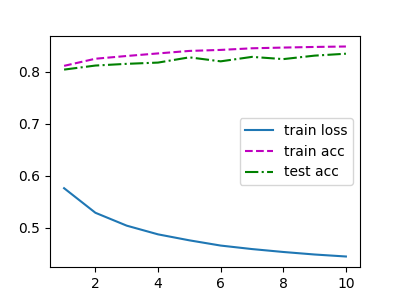

In [14]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

预测结果

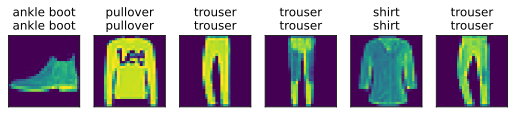

In [3]:
predict_ch3(net, test_iter)